# Evaluating a Modern Polish POS-Tagger on Historical Data
### by Maria Irena Szawerna

### IMPORTS, VARIABLES, AND PARAMETERS

In [1]:
import requests
import math
import sklearn.metrics
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

pd.set_option('display.max_rows', None)

In [2]:
# from https://cloud.gate.ac.uk/shopfront/displayItem/tagger-pos-pl-maxent1 - "A POS tagger for pl / Polish using the Universal 
# Dependencies POS tagset.
# instructions on how to use the API from https://cloud.gate.ac.uk/info/help/online-api.html

URL = 'https://cloud-api.gate.ac.uk/process/tagger-pos-pl-maxent1'
PARAMS = {
    'Content-Type': 'text/plain',
    'Accept': 'application/json'
}
file = 'memoirs_annotated_3k.txt'

### FUNCTIONS AND CLASSES

In [3]:
def retrieve_text(filename: str):
    '''A function intended for opening and reading a text file, with lines being stripped of leading and trailing whitespace.
    
    Args:
        filename (str): The name of the file or path to the file that is to be opened.
        
    Returns:
        A list of strings representing the lines in the file, stripped of whitespace on the edges.
    '''
    with open(filename) as f:
        lines = f.readlines()
        
        all_lines = []
        for line in lines:
            all_lines.append(line.strip())
        return all_lines

In [4]:
class OriginalAnnotations:
    '''A class intended to process and store the tokens and their respective annotations from the original text.
    
    Attributes:
        tokens (list[str]): A list of all the tokens (without annotation) in the original data. Every element of the list is a string.
        gold_standard (list[str]): A list of all the original annotations (without tokens). Every element is a string.
    '''
    def __init__(self, data: list, lowercase: bool = False):
        '''The __init__ method of the class.
        Constructs the token and gold_standard lists.
        
        Args:
            data (list[str]): A list of annotated sentences. Every element of the list is a string representing the whole sentence.
            lowercase (bool): Determines whether the tokens should be lowercased or if original capitalization should be retained.
        '''
        self.tokens = []
        self.gold_standard = []
        
        for sentence in text:
            sentence.strip()
            sentence = sentence.split(" ")
            for annotated_token in sentence:
                if annotated_token[0] == '[':
                    annotated_token = annotated_token[1:]
                if annotated_token[-1] == ']':
                    annotated_token = annotated_token[:-1]
                split_token = annotated_token.split('_')
                if not lowercase:
                    self.tokens.append(split_token[0])
                else:
                    self.tokens.append(split_token[0].lower())
                self.gold_standard.append(split_token[1])
                
    def __len__(self):
        '''The __len__ magic method of the class.
            
        Returns:
            The length of self.tokens, which should be identical to the length of self.gold_standard.
        '''
        return len(self.tokens)
        
    def __getitem__(self, index: int):
        '''The __getitem__ magic method of the class.
            
        Args:
            index (int): The index signifying the desired element.
            
        Returns:
            A string representing the combination of the original token and annotation.
        '''
        token = self.tokens[index]
        annotation = self.gold_standard[index]
        item = '_'.join([token, annotation])
            
        return item

In [5]:
class TaggerAnnotations:
    '''A class intended for retrieving, processing, and storing the annotations from an online tagger.
    
    Attributes:
        processed_annotations (list[list]): A list of lists, every element of which represents a number of values returned by the
            tagger. The values include the token, the POS tag, the confidence thereof, a list of possible targets and a list
            of those confidences.
        only_annotations (list[str]): A list containing only the POS tags obtained from the tagger.    
    '''
    def __init__(self, url: str, headers: dict, data: list):
        '''The __init__ method of the class.
        Retrieves the tagger annotations (in batches, if needed), constructs processed_annotations and only_annotations using
        the __retrieve_anns method.
        
        Args:
            url (str): The URL to which the query should be made.
            headers (dict): The parameters that the query requires.
            data (list[str]): The original, unannotated data represented as a list of individual tokens (not sentences).        
        '''
        self.processed_annotations = []
        self.only_annotations = []
        
        if len(data) > 1000:  # this is required due to the tagger bottleneck
            prev_i = 0
            for i in range(1, math.floor(len(data)/1000)):
                subset = data[prev_i*1000:i*1000]
                prev_i = i
                subset = ' '.join(subset)
                r = requests.post(url=url, data=subset.encode('utf-8'), headers=headers)
                annotations = r.json()
                for entry in tqdm(annotations['entities']['Token'], desc='Loading annotations...'):
                    self.__retrieve_anns(entry)
                    
            subset = data[prev_i*1000:]
            subset = ' '.join(subset)
            r = requests.post(url=url, data=subset.encode('utf-8'), headers=headers)
            annotations = r.json()
            for entry in tqdm(annotations['entities']['Token'], desc='Loading annotations...'):
                self.__retrieve_anns(entry)        
            
        
        else:
            data = ' '.join(data)

            r = requests.post(url=url, data=data.encode('utf-8'), headers=headers) 
            self.annotations = r.json()

            for entry in tqdm(annotations['entities']['Token'], desc='Loading annotations...'):
                self.__retrieve_anns(entry)

    def print_annotations(self):
        '''A method of the class which prints out all words with their annotation and the confidence thereof.
        '''
        for entry in self.processed_annotations:
            print(entry[0] + ' | ' + entry[1] + ' | ' + str(entry[2]))
            
    def __retrieve_anns(self, entry: dict):
        '''A method of the class which reads the data returned by the tagger and stores the relevant elements in appropriate
        lists.
        
        Args:
            entry (dict): An entry returned by the tagger.
        '''
        word = entry['string']
        pos = entry['upos']
        confidence = entry['LF_confidence']
        target_list = entry['LF_target_list']
        confidence_list = entry['LF_confidence_list']

        annotation = [word, pos, confidence, target_list, confidence_list]
        self.processed_annotations.append(annotation)
        self.only_annotations.append(pos)
        
    def __len__(self):
        '''The __len__ magic method of the class.
            
        Returns:
            The length of self.only_annotations, which should be identical to the length of self.processed_annotations.
        '''
        return len(self.only_annotations)
        
    def __getitem__(self, index: int):
        '''The __getitem__ magic method of the class.
            
        Args:
            index (int): The index signifying the desired element.
            
        Returns:
            A string representing the combination of the original token and the tagger annotation.
        '''
        full_ann = self.processed_annotations[index]
        token = full_ann[0]
        annotation = full_ann[1]
        item = '_'.join([token, annotation])
            
        return item
        

In [6]:
def get_measures(gold_standard: list, predictions: list):
    '''A function intended for retrieving a selection of evaluation measures for comparing the gold standard and the tagger
    annotations. The measures are printed out and include accuracy, Matthew's Correlation Coefficient, per-class precision 
    and recall, as well as a confusion matrix, which, in addition, get saved locally. These measures are calculated using 
    functions from sklearn and pyplot.
    
    Args:
        gold_standard (list[str]): A list of gold standard labels.
        predictions (list[str]): A list of predicted labels.
    '''
    labels = sorted(list(set(gold_standard)))
    print('MEASURES:')
    print(f'Accuracy: {"{:.2%}".format(sklearn.metrics.accuracy_score(gold_standard, predictions))}')
    print(f'Matthew\'s Correlation Coefficient: {"{:.2%}".format(sklearn.metrics.matthews_corrcoef(gold_standard, predictions))}')
    print()
    print('MEASURES PER CLASS:')
    precision = sklearn.metrics.precision_score(gold_standard, predictions, average=None, labels=labels)
    print('Precision:')
    for i in range(0,len(labels)):
        print(f'\t{labels[i]}: {"{:.2%}".format(precision[i])}')
    recall = sklearn.metrics.recall_score(gold_standard, predictions, average=None, labels=labels)
    print('Recall:')
    for i in range(0,len(labels)):
        print(f'\t{labels[i]}: {"{:.2%}".format(recall[i])}')
    print()
    print('Confusion matrix:')
    cm = sklearn.metrics.confusion_matrix(gold_standard, predictions)
    matrix = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(12,12))
    matrix.plot(ax=ax)
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig("./images/" + timestr + "confusion_matrix.jpg")
    

In [7]:
def get_problematic_anns(
    gold_standard: list, 
    predictions: list, 
    processed_annotations: list, 
    tokens: list
):
    '''A function intended for collecting the wrong annotations from the tagger and storing them in a DataFrame with the 
    original token, context, gold standard, prediction, and the confidence of that prediction.
    
    Args:
        gold_standard (list[str]): A list of gold standard tags represented as strings.
        predictions (list[str]): A list of predicted tags represented as strings.
        processed_annotations (list[list]): A list of lists where every element represents information about the annotation as
            obtained from the tagger.
        tokens (list[str]): A list of the original tokens.
        
    Returns:
        A DataFrame containing the original token, context, gold standard, prediction, and the confidence of that prediction 
        for every mismatched prediction and gold standard.
    '''
    problematic = []
    for i in range(0, len(tokens)):
        
        if gold_standard[i] != predictions[i]:
            if i != 0:
                preceding = tokens[i-1]
            else:
                preceding = ''
                
            if i != len(tokens)-1:
                succeeding = tokens[i+1]
            else:
                succeeding = ''
                
            problematic.append(
                (tokens[i], 
                 ' '.join([preceding, tokens[i], succeeding]), 
                 gold_standard[i], 
                 predictions[i], 
                 processed_annotations[i][2])
            )
            
    problematic_frame = pd.DataFrame(problematic, columns=['Token', 'Context', 'Gold Standard', 'Prediction', 'Confidence'])
    
    return problematic_frame

### RESULTS (non-lowercase)

In [8]:
# retrieving the lines from the annotated file
text = retrieve_text(file)

In [9]:
# creating an OriginalAnnotations object to store the tokens and original annotations
original_text = OriginalAnnotations(text)

In [10]:
# creating a TaggerAnnotations object to retrieve and store tagger annotations
tagger_anns = TaggerAnnotations(URL, PARAMS, original_text.tokens)

Loading annotations...: 100%|███████████████████████████████████████████████████| 1270/1270 [00:00<00:00, 431596.67it/s]


In [11]:
# sanity check
for i in range(0,len(tagger_anns.processed_annotations)):
    if tagger_anns.processed_annotations[i][0] != original_text.tokens[i]:
        print(f'mismatch at {i}: {tagger_anns.processed_annotations[i][0]} and {original_text.tokens[i]}')
        print()

MEASURES:
Accuracy: 83.98%
Matthew's Correlation Coefficient: 81.82%

MEASURES PER CLASS:
Precision:
	ADJ: 61.51%
	ADP: 95.65%
	ADV: 72.29%
	AUX: 76.92%
	CCONJ: 97.52%
	DET: 98.46%
	NOUN: 84.94%
	NUM: 73.68%
	PART: 82.22%
	PRON: 82.89%
	PROPN: 66.23%
	PUNCT: 100.00%
	SCONJ: 80.43%
	VERB: 84.40%
	X: 64.52%
Recall:
	ADJ: 78.90%
	ADP: 97.06%
	ADV: 70.59%
	AUX: 74.63%
	CCONJ: 95.73%
	DET: 42.11%
	NOUN: 79.56%
	NUM: 65.12%
	PART: 59.68%
	PRON: 88.73%
	PROPN: 93.09%
	PUNCT: 100.00%
	SCONJ: 53.62%
	VERB: 90.38%
	X: 52.63%

Confusion matrix:


FileNotFoundError: [Errno 2] No such file or directory: './images/20221229-214541confusion_matrix.jpg'

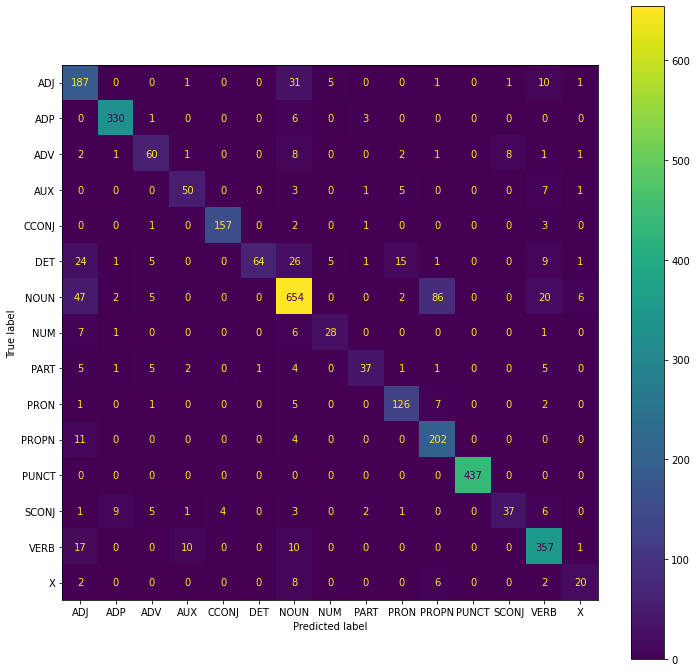

In [12]:
# evaluating the tagger annotations
get_measures(original_text.gold_standard, tagger_anns.only_annotations)

In [ ]:
# constructing a frame containing problematic annotations
frame = get_problematic_anns(
    original_text.gold_standard, 
    tagger_anns.only_annotations, 
    tagger_anns.processed_annotations, 
    original_text.tokens
)

In [ ]:
# printing out the frame
frame

In [ ]:
# printing out the frame sorted by gold standard values
frame.sort_values('Gold Standard')

### RESULTS (lowercase)

In [ ]:
# creating an OriginalAnnotations object to store the tokens and original annotations, in lowercase
original_lowercase = OriginalAnnotations(text, lowercase=True)

In [ ]:
# creating a TaggerAnnotations object to retrieve and store tagger annotations for lowercase tokens
tagger_lowercase = TaggerAnnotations(URL, PARAMS, original_lowercase.tokens)

In [ ]:
# sanity check
for i in range(0,len(tagger_lowercase.processed_annotations)):
    if tagger_lowercase.processed_annotations[i][0] != original_lowercase.tokens[i]:
        print(f'mismatch at {i}: {tagger_lowercase.processed_annotations[i][0]} and {original_lowercase.tokens[i]}')
        print()

In [ ]:
# evaluating the tagger annotations on lowercase tokens
get_measures(original_lowercase.gold_standard, tagger_lowercase.only_annotations)

In [ ]:
# constructing a frame containing problematic annotations for lowercase tokens
frame_lower = get_problematic_anns(
    original_lowercase.gold_standard, 
    tagger_lowercase.only_annotations, 
    tagger_lowercase.processed_annotations, 
    original_lowercase.tokens
)

In [ ]:
# printing out the frame
frame_lower

In [ ]:
# printing out the frame sorted by gold standard values
frame_lower.sort_values('Gold Standard')